In [35]:
# Import libraries
import pickle
import matplotlib.pyplot as plt
import gensim.matutils
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, Word2Vec
from scipy.sparse import csr_matrix
from gensim.corpora import Dictionary
from nltk.corpus import wordnet

In [2]:
# Define the file path
pickle_file = 'processed_data.pkl'

In [3]:
# Read the processed data from the Pickle file
with open(pickle_file, 'rb') as file:
    processed_data = pickle.load(file)

In [4]:
# Retrieve data
title = processed_data['title']
abstract = processed_data['abstract']

In [5]:
title

0                               [reconstruct, effect, map]
1                  [rotation, invariance, neural, network]
2        [spherical, polyharmonics, poisson, kernels, p...
3        [finite, element, approximation, stochastic, m...
4        [comparative, study, discrete, wavelet, transf...
                               ...                        
20967    [contemporary, machine, learn, guide, practiti...
20968    [uniform, diamond, coat, hard, alloy, cut, ins...
20969         [analyse, soccer, game, cluster, conceptors]
20970    [efficient, simulation, sum, correlate, variates]
20971                 [optional, stop, problem, bayesians]
Name: title, Length: 20972, dtype: object

In [6]:
abstract

0        [predictive, model, allow, inference, analyze,...
1        [rotation, invariance, translation, invariance...
2        [introduce, develop, notion, spherical, polyha...
3        [stochastic, landau, lifshitz, gilbert, llg, e...
4        [ftir, spectra, sample, 7, plant, species, use...
                               ...                        
20967    [machine, learn, find, increasingly, broad, ap...
20968    [polycrystalline, diamond, coat, grow, cement,...
20969    [present, new, approach, identify, situations,...
20970    [sum, variates, encounter, many, challenge, ap...
20971    [recently, optional, stop, subject, debate, ba...
Name: abstract, Length: 20972, dtype: object

In [7]:
# Concatenate titles and abstracts
documents = [" ".join(t) + " " + " ".join(a) for t, a in zip(title, abstract)]

In [8]:
# Define the range of values for max_df and min_df to search over
param_grid = {
    'max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    'min_df': [2, 3, 4, 5]
}

In [9]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

In [10]:
# Perform grid search with specified scoring metric
grid_search = GridSearchCV(estimator=tfidf_vectorizer, param_grid=param_grid, cv=5, scoring='neg_log_loss')
grid_search.fit(documents)

C:\Users\Ang Soo Khee\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Ang Soo Khee\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\Ang Soo Khee\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5, estimator=TfidfVectorizer(stop_words='english'),
             param_grid={'max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
                         'min_df': [2, 3, 4, 5]},
             scoring='neg_log_loss')

In [11]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_df': 0.7, 'min_df': 2}


In [12]:
# Get the best estimator
best_estimator = grid_search.best_estimator_

In [13]:
# Transform the documents using the best estimator
tfidf_matrix = best_estimator.transform(documents)

In [14]:
# Convert tfidf_matrix to a corpus for LSA
corpus = gensim.matutils.Sparse2Corpus(tfidf_matrix.T)

In [15]:
# Tokenize documents into lists of words
tokenized_documents = [doc.split() for doc in documents]

In [16]:
# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_documents)

In [17]:
# Set up parameters for LSA
num_topics_range = [5, 10, 15, 20, 25, 30, 35, 40]

In [18]:
# Initialize coherence_scores list
coherence_scores = []


# Calculate coherence score
for num_topics in num_topics_range:
    # Apply Truncated SVD for LSA using the best parameters
    lsa_model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    lsa_matrix = lsa_model[corpus]
    
    # Extract list of words for each topic
    topics = [topic[1] for topic in lsa_model.show_topics(num_topics=num_topics)]
    
    # Calculate coherence score
    coherence_model = CoherenceModel(topics=topics, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

In [19]:
print("Coherence Scores:", coherence_scores)

Coherence Scores: [0.6485410336043301, 0.6635579820884703, 0.6600398591570269, 0.6566168144204019, 0.6774000191010328, 0.6869100618269178, 0.6913675249538507, 0.6872582221614563]


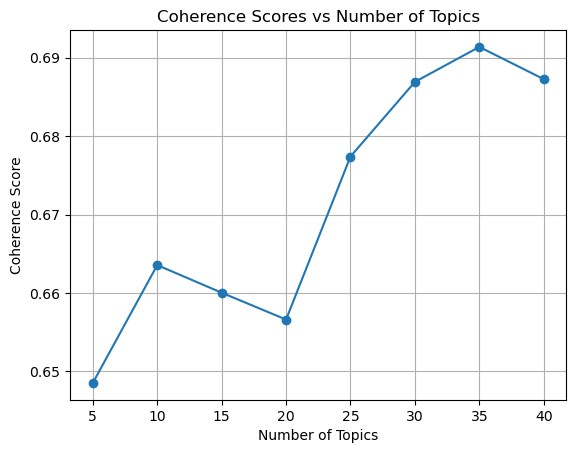

In [20]:
# Plot the coherence scores
plt.plot(num_topics_range, coherence_scores, marker='o')
plt.title('Coherence Scores vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.show()

In [21]:
# Choose the optimal number of topics based on the highest coherence score
num_topics_optimal = num_topics_range[coherence_scores.index(max(coherence_scores))]
print("Optimal Number of Topics:", num_topics_optimal)

Optimal Number of Topics: 35


In [22]:
# Apply LSA with the Optimal Number of Topics
lsa_model_optimal = LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics_optimal)
lsa_matrix_optimal = lsa_model_optimal[corpus]

Topic 0: 0.242*"supersymmetry" + 0.214*"broadcasters" + 0.196*"véronique" + 0.167*"db" + 0.157*"humid" + 0.125*"minibatch" + 0.113*"practical" + 0.112*"inadequacy" + 0.106*"sublattices" + 0.105*"isochrones"


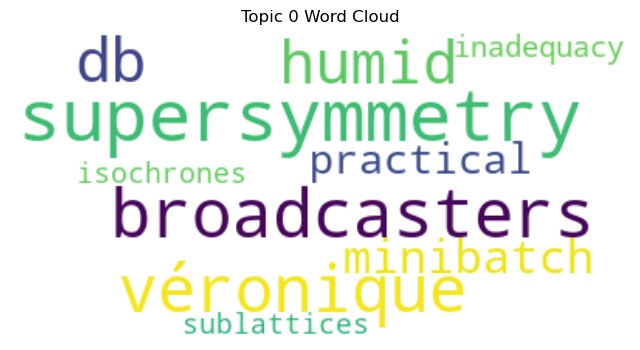

Topic 1: -0.371*"broadcasters" + -0.333*"véronique" + -0.216*"viewers" + -0.196*"acvae" + -0.190*"protosun" + 0.117*"duplication" + 0.117*"lda" + 0.114*"lieu" + -0.114*"flink" + 0.100*"dow"


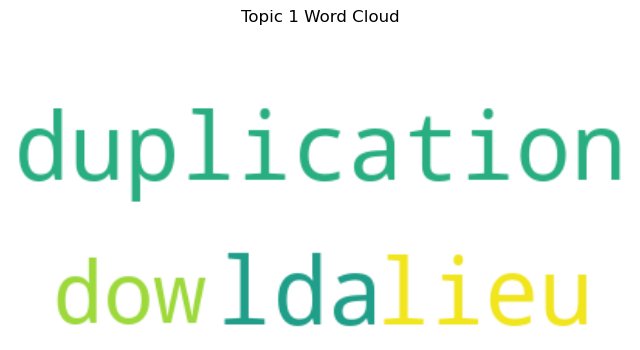

Topic 2: 0.528*"soap" + -0.188*"supersymmetry" + 0.168*"versus" + -0.150*"wavefront" + 0.149*"isochrones" + -0.140*"nika" + -0.130*"sixties" + -0.117*"duplication" + -0.111*"lda" + -0.105*"gier"


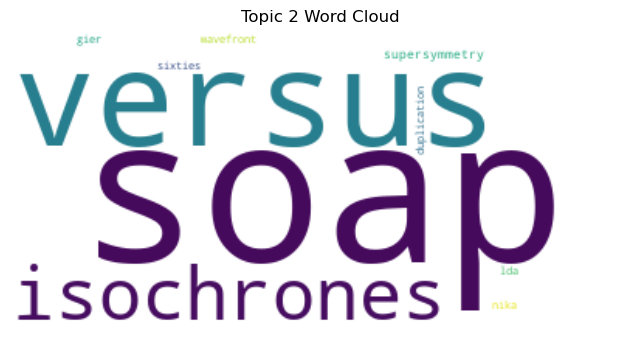

Topic 3: 0.549*"broadcasters" + 0.423*"soap" + -0.184*"db" + 0.159*"viewers" + -0.132*"véronique" + -0.125*"supersymmetry" + 0.117*"lieu" + 0.107*"duplication" + -0.104*"smoteboost" + -0.104*"versus"


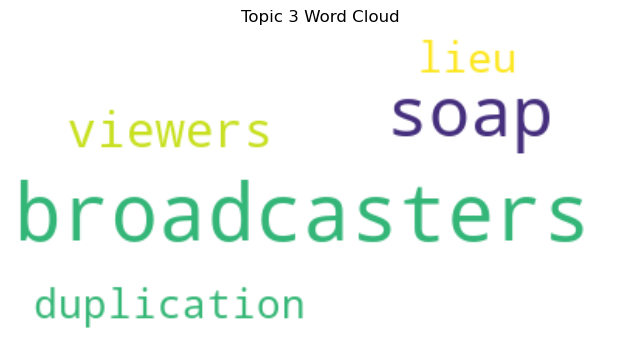

Topic 4: 0.565*"soap" + 0.283*"supersymmetry" + -0.222*"broadcasters" + -0.190*"dow" + 0.187*"db" + -0.156*"lieu" + -0.150*"viewers" + 0.147*"subcode" + -0.133*"bharanedhar" + -0.122*"acvae"


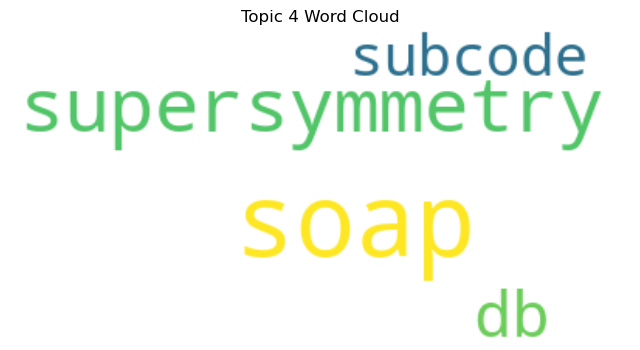

Topic 5: 0.455*"véronique" + -0.448*"broadcasters" + 0.220*"lieu" + 0.173*"soap" + -0.159*"supersymmetry" + 0.153*"fu" + 0.116*"duplication" + 0.114*"flink" + -0.111*"curtailment" + 0.110*"acvae"


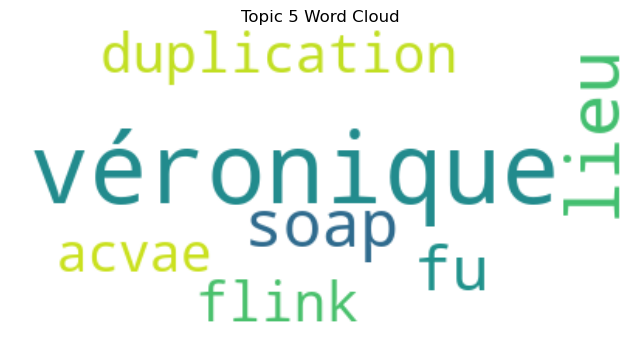

Topic 6: 0.527*"supersymmetry" + 0.303*"lieu" + -0.221*"versus" + -0.147*"backup" + -0.141*"tomographic" + -0.133*"isochrones" + 0.128*"bharanedhar" + -0.128*"contour" + 0.105*"db" + -0.100*"incentivizing"


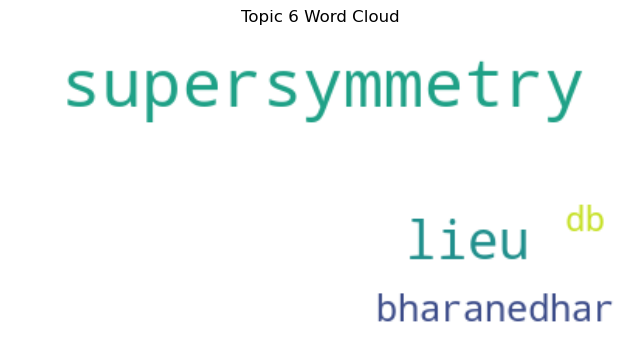

Topic 7: -0.381*"supersymmetry" + -0.296*"véronique" + 0.255*"fu" + 0.236*"subcode" + 0.235*"lieu" + 0.226*"db" + -0.165*"soap" + -0.159*"sixties" + -0.156*"duplication" + 0.111*"tritellurides"


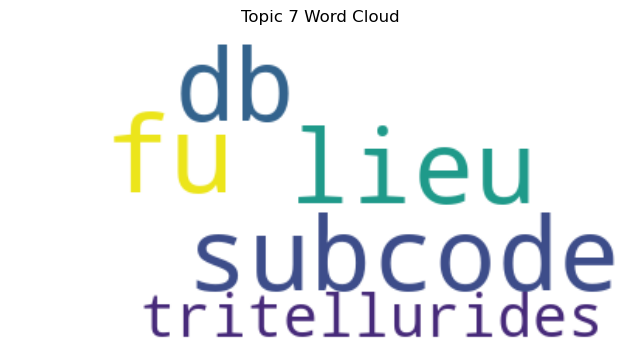

Topic 8: 0.220*"lieu" + -0.209*"dow" + -0.206*"smoteboost" + 0.203*"tomographic" + 0.189*"aptasensors" + -0.187*"fu" + 0.149*"supersymmetry" + -0.142*"protosun" + 0.129*"encapsulations" + -0.112*"subcode"


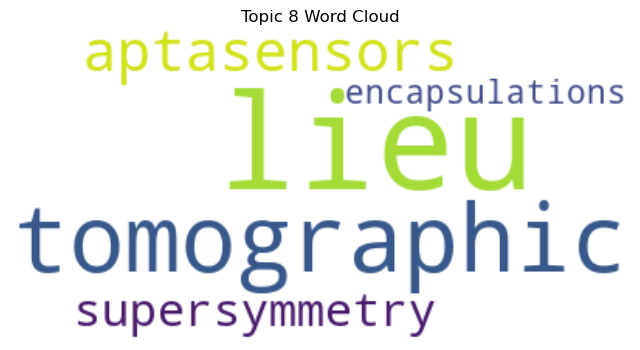

Topic 9: -0.353*"fu" + 0.309*"lieu" + -0.237*"beamformer" + -0.231*"binaurally" + 0.226*"duplication" + -0.221*"harshaw" + -0.162*"soap" + 0.158*"subcode" + 0.140*"versus" + 0.132*"smoteboost"


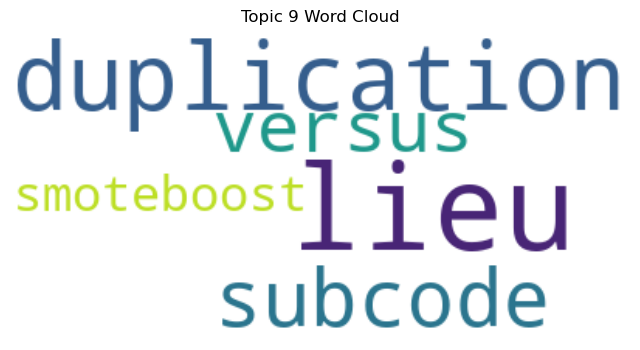

Topic 10: 0.392*"fu" + -0.316*"véronique" + -0.306*"subcode" + 0.232*"duplication" + -0.205*"tritellurides" + -0.160*"approximant" + 0.145*"inadequacy" + -0.142*"levitch" + 0.117*"nika" + -0.112*"longevity"


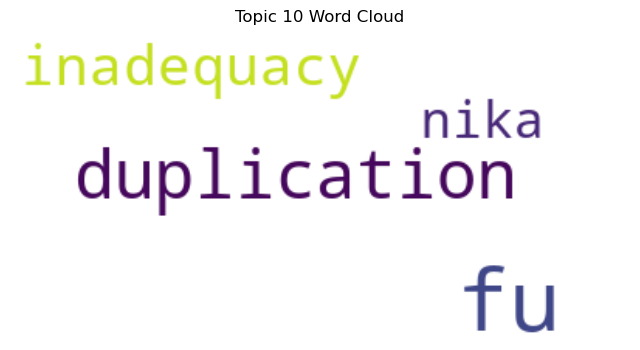

Topic 11: -0.525*"db" + 0.293*"lieu" + 0.276*"supersymmetry" + 0.192*"fu" + 0.177*"versus" + 0.145*"tritellurides" + 0.119*"backup" + -0.110*"duplication" + 0.110*"approximant" + 0.101*"curtailment"


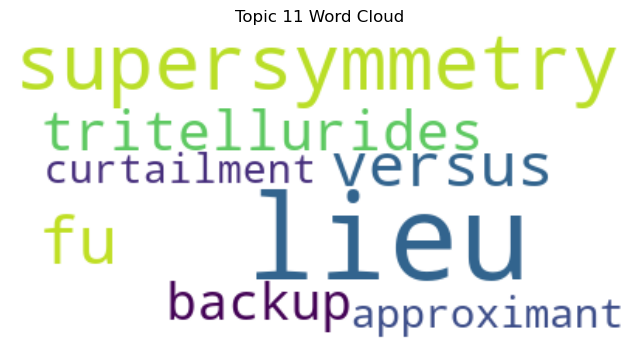

Topic 12: 0.477*"subcode" + -0.264*"dow" + 0.190*"db" + 0.187*"duplication" + 0.186*"versus" + 0.181*"binaurally" + 0.175*"beamformer" + 0.163*"harshaw" + 0.158*"lieu" + 0.136*"inadequacy"


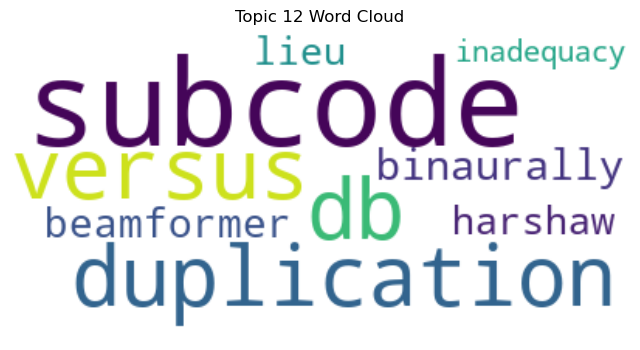

Topic 13: 0.409*"lieu" + -0.322*"duplication" + -0.295*"subcode" + -0.295*"dow" + 0.163*"smoteboost" + -0.158*"supersymmetry" + -0.152*"bharanedhar" + 0.125*"binaurally" + 0.116*"véronique" + 0.116*"wavefront"


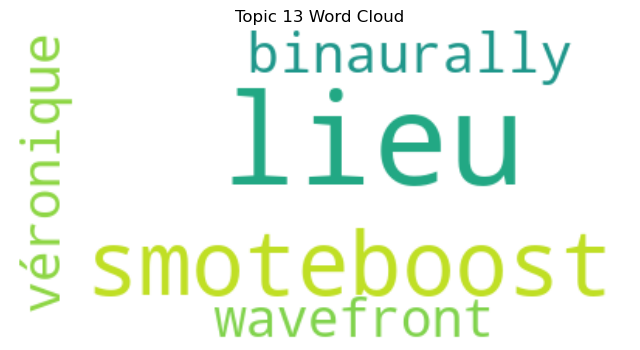

Topic 14: -0.421*"duplication" + 0.212*"wavefront" + -0.181*"fu" + -0.170*"smoteboost" + -0.165*"tomographic" + 0.158*"supersymmetry" + 0.146*"rcgans" + 0.136*"lda" + -0.136*"aptasensors" + 0.135*"versus"


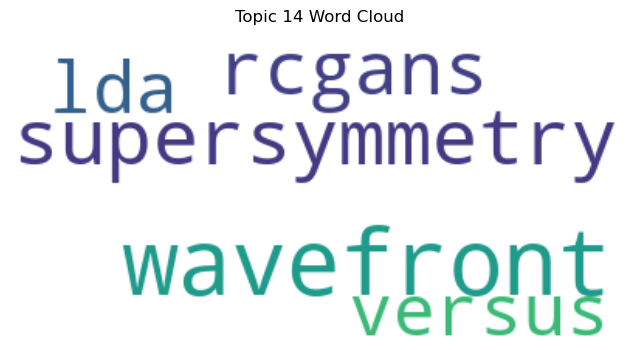

Topic 15: -0.337*"tube" + -0.326*"protosun" + -0.203*"adversely" + 0.177*"dow" + 0.174*"fu" + -0.171*"duplication" + 0.146*"véronique" + 0.137*"brainer" + -0.129*"smoteboost" + 0.120*"inadequacy"


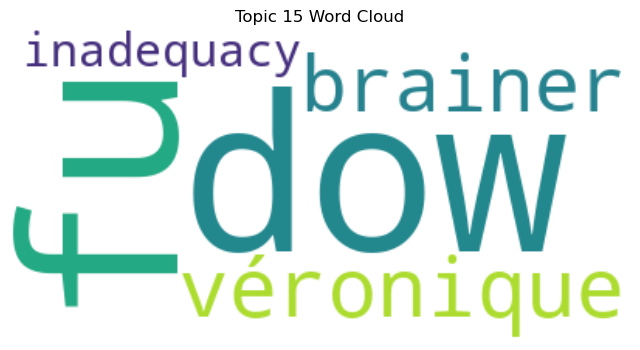

Topic 16: -0.286*"bharanedhar" + 0.230*"dow" + 0.200*"duplication" + -0.191*"tube" + -0.165*"tomographic" + -0.162*"discontent" + -0.160*"smoteboost" + 0.149*"viewers" + -0.139*"rcgans" + 0.131*"lieu"


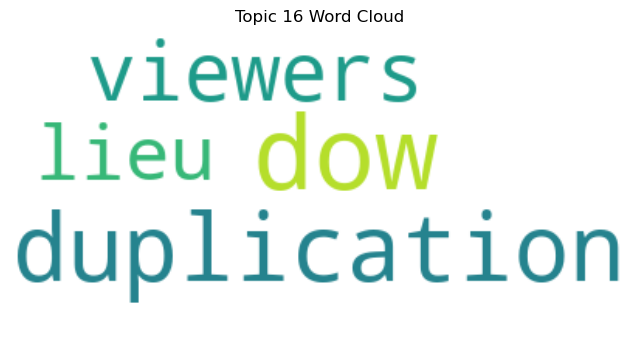

Topic 17: 0.445*"dow" + 0.275*"subcode" + 0.242*"tomographic" + 0.234*"tube" + -0.200*"versus" + -0.183*"bharanedhar" + 0.168*"lieu" + 0.152*"adversely" + -0.132*"coformal" + 0.131*"protosun"


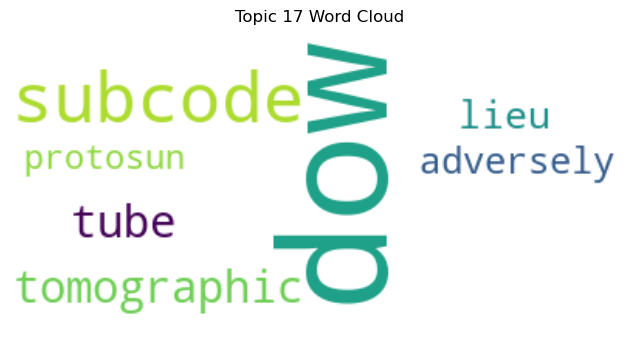

Topic 18: 0.384*"fu" + -0.247*"bharanedhar" + -0.229*"inadequacy" + -0.163*"rcgans" + 0.155*"db" + 0.154*"isochrones" + -0.153*"tomographic" + 0.139*"separator" + 0.134*"supercomputers" + -0.128*"aptasensors"


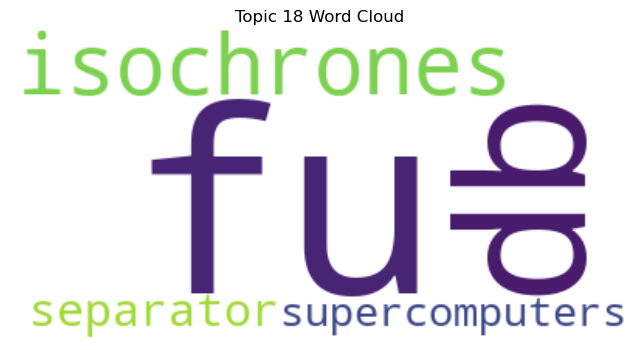

Topic 19: -0.330*"subcode" + 0.224*"duplication" + 0.197*"backup" + 0.180*"curtailment" + 0.175*"multicentric" + 0.172*"db" + 0.172*"bharanedhar" + -0.146*"tomographic" + -0.138*"coformal" + -0.135*"ramachandran"


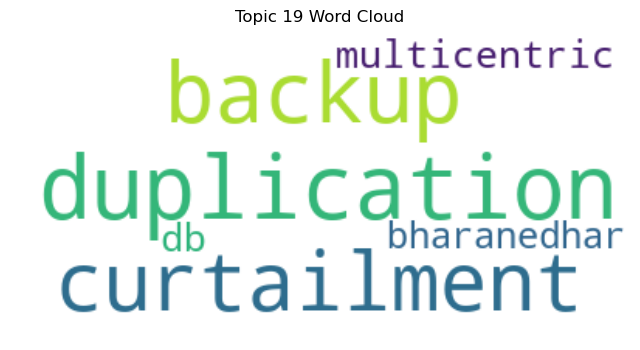

Topic 20: -0.261*"db" + 0.257*"lda" + -0.208*"toolchain" + -0.197*"dow" + 0.179*"smoteboost" + 0.170*"encapsulations" + -0.170*"lieu" + -0.153*"tomographic" + 0.149*"brainer" + 0.142*"tube"


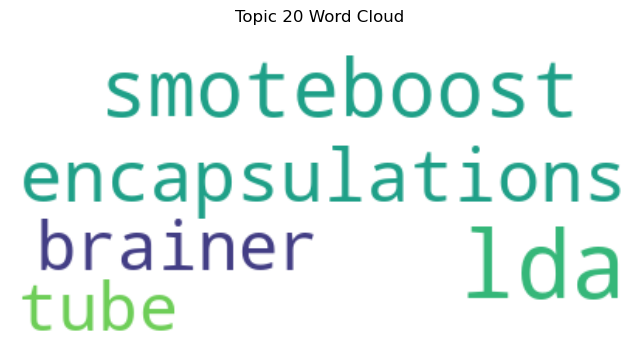

Topic 21: -0.366*"lda" + -0.261*"tomographic" + -0.204*"db" + 0.202*"callhome" + 0.186*"nika" + 0.152*"curtailment" + -0.143*"wavefront" + -0.125*"duplication" + 0.124*"separator" + -0.124*"coformal"


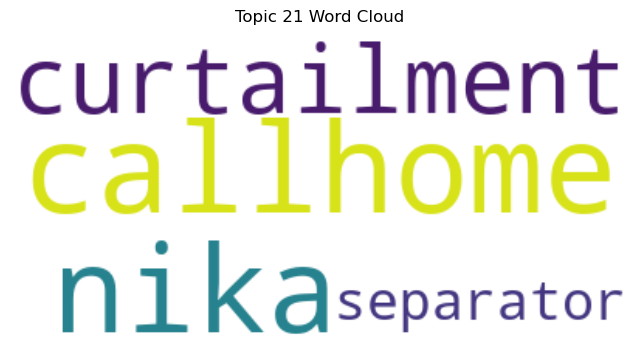

Topic 22: -0.299*"fods" + -0.271*"toolchain" + 0.172*"coformal" + -0.168*"curtailment" + -0.161*"viewers" + 0.158*"tube" + -0.148*"encapsulations" + 0.146*"callhome" + -0.138*"sixties" + 0.133*"lambertson"


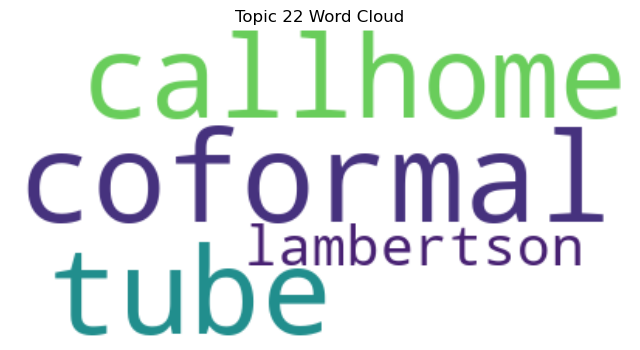

Topic 23: -0.298*"isochrones" + 0.245*"subcode" + 0.207*"curtailment" + -0.206*"encapsulations" + -0.181*"tritellurides" + 0.167*"lda" + 0.167*"fods" + 0.131*"deepwalk" + 0.127*"multicentric" + -0.125*"incentivizing"


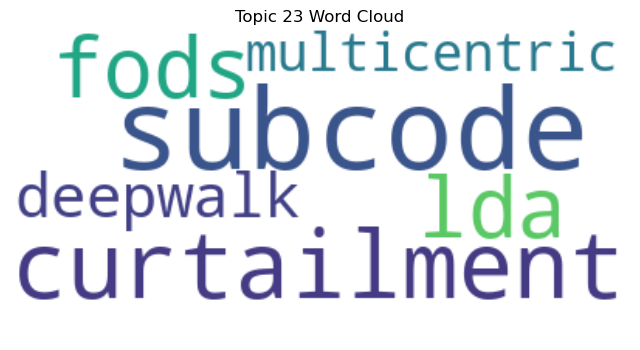

Topic 24: -0.239*"dow" + 0.207*"coformal" + 0.205*"aptasensors" + 0.187*"tomographic" + 0.186*"curtailment" + -0.157*"inadequacy" + 0.144*"nika" + -0.142*"versus" + -0.139*"smoteboost" + 0.134*"442"


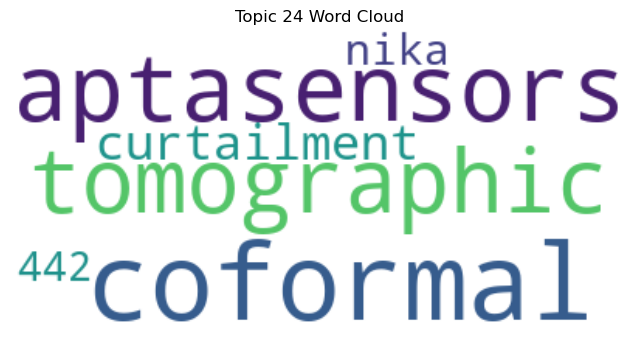

Topic 25: 0.297*"coformal" + -0.268*"lda" + -0.251*"duplication" + 0.190*"tube" + 0.178*"versus" + 0.171*"brainer" + 0.167*"sixties" + 0.161*"dow" + -0.157*"wavefront" + 0.139*"aptasensors"


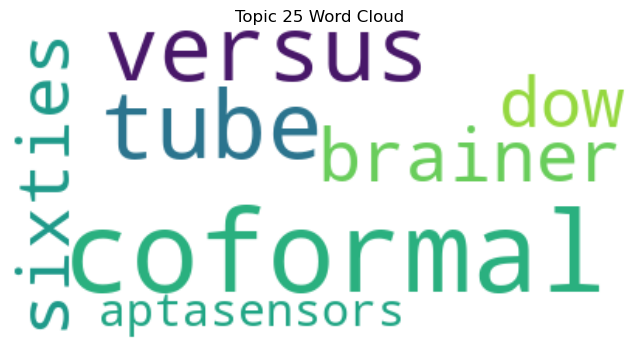

Topic 26: -0.243*"lda" + -0.233*"bharanedhar" + 0.232*"rcgans" + -0.198*"versus" + -0.194*"toolchain" + -0.177*"wavefront" + 0.175*"deepwalk" + -0.172*"adversely" + 0.162*"encapsulations" + 0.158*"fu"


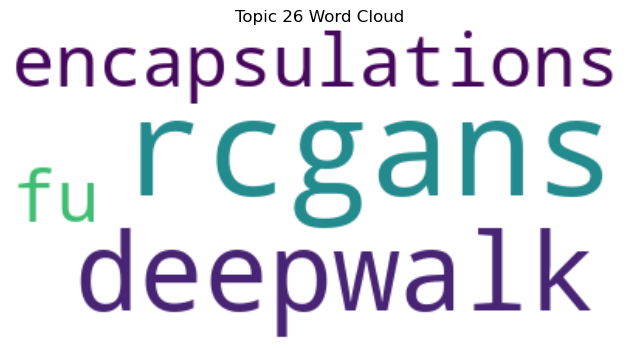

Topic 27: 0.374*"bharanedhar" + -0.274*"rcgans" + 0.201*"effort" + -0.185*"inadequacy" + -0.164*"authoritative" + -0.156*"supercomputers" + 0.147*"nika" + 0.132*"downlink" + -0.132*"coformal" + -0.132*"trilayers"


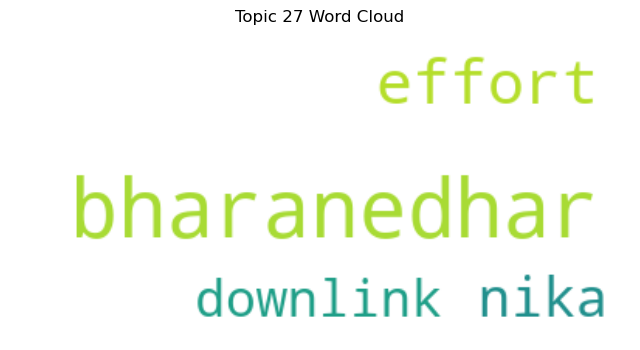

Topic 28: 0.401*"macdonlald" + -0.255*"sixties" + 0.223*"nika" + -0.167*"effort" + 0.149*"rjmcmc" + -0.143*"fods" + -0.134*"wavefront" + -0.128*"gier" + 0.127*"unequal" + -0.123*"rcgans"


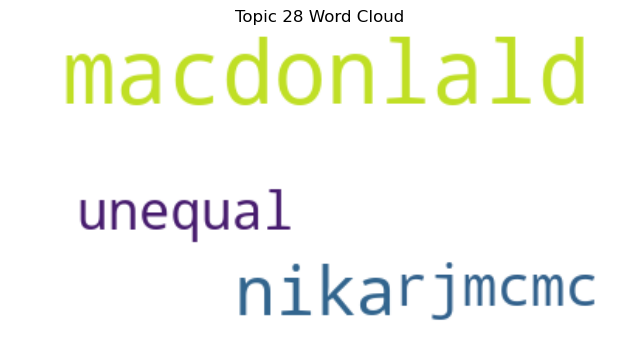

Topic 29: -0.290*"effort" + 0.224*"supercomputers" + -0.195*"nika" + -0.189*"inadequacy" + 0.154*"acvae" + 0.149*"laminar" + -0.145*"deepwalk" + 0.143*"sixties" + -0.137*"cure" + -0.136*"multivarsel"


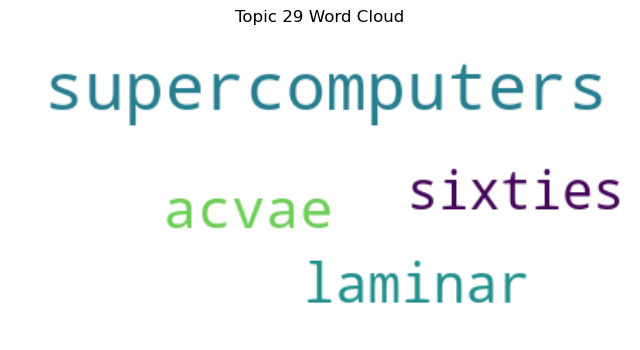

Topic 30: -0.321*"callhome" + 0.244*"nika" + 0.217*"coformal" + -0.202*"rarefy" + -0.172*"rcgans" + 0.162*"protosun" + -0.153*"toolchain" + 0.146*"flink" + -0.135*"helices" + 0.133*"dbd"


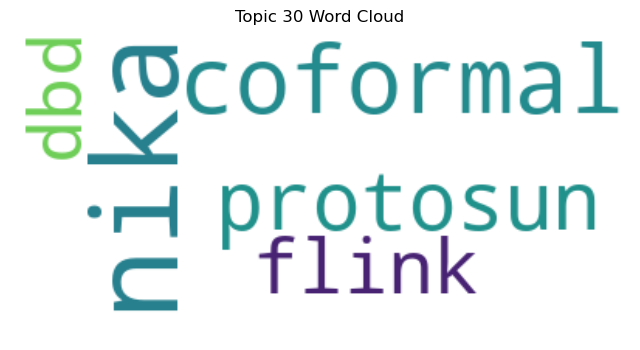

Topic 31: 0.258*"nika" + -0.240*"supercomputers" + -0.238*"bharanedhar" + 0.186*"rcgans" + 0.171*"authoritative" + 0.149*"think" + 0.146*"adversely" + -0.139*"protosun" + -0.139*"brainer" + 0.135*"avenues"


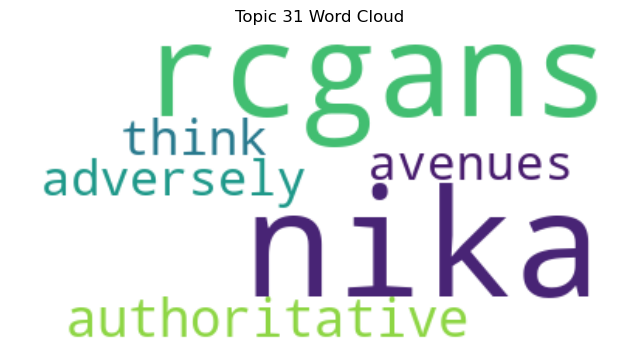

Topic 32: 0.431*"supercomputers" + -0.179*"downlink" + 0.167*"effort" + 0.160*"deepwalk" + -0.146*"curtailment" + 0.137*"encapsulations" + 0.136*"tritellurides" + -0.134*"isochrones" + 0.134*"inadequacy" + 0.133*"nika"


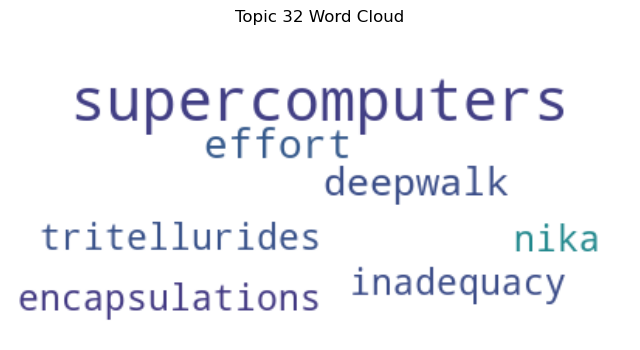

Topic 33: 0.313*"smoteboost" + -0.240*"authoritative" + 0.238*"versus" + 0.208*"tomographic" + 0.174*"dow" + -0.173*"supercomputers" + -0.168*"isochrones" + 0.154*"deepwalk" + -0.153*"downlink" + -0.151*"fods"


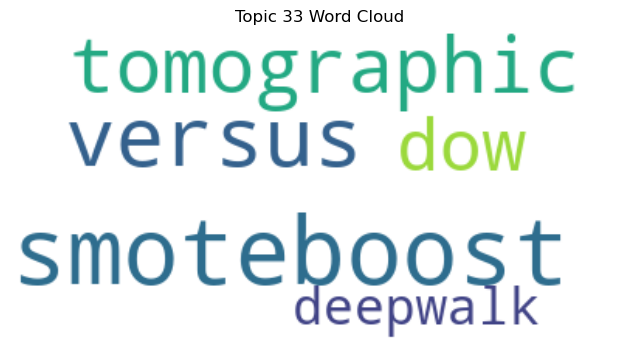

Topic 34: -0.250*"callhome" + -0.245*"fods" + 0.211*"sixties" + -0.201*"supercomputers" + 0.201*"inadequacy" + -0.196*"coformal" + -0.193*"unequal" + -0.166*"isochrones" + 0.161*"macdonlald" + -0.140*"rcgans"


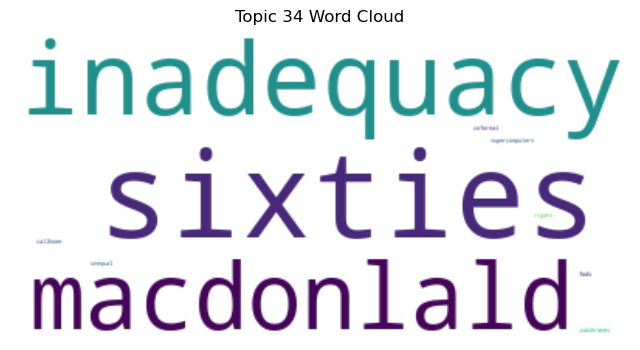

In [23]:
# Visualization of Topics (Word Clouds)
topics = lsa_model_optimal.show_topics(num_topics=num_topics_optimal, num_words=10)

for topic_id, topic in topics:
    print(f"Topic {topic_id}: {topic}")
    
    # Extract words and probabilities from the topic representation string
    word_prob_pairs = [pair.split("*") for pair in topic.split(" + ")]
    words = [pair[1][1:-1] for pair in word_prob_pairs]
    probabilities = [float(pair[0]) for pair in word_prob_pairs]
    word_prob_dict = dict(zip(words, probabilities))
    
    # Generate word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_prob_dict)
    
    # Plot word cloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {topic_id} Word Cloud')
    plt.axis('off')
    plt.show()


In [24]:
# Examine the Top Words & Interpret the Words
for topic_id, topic in topics:
    print(f"\nTopic {topic_id}:")
    top_words = [pair.split("*") for pair in topic.split(" + ")]
    top_words = [(float(weight), word.strip('"')) for weight, word in top_words]
    top_words.sort(reverse=True)
    print("Top Words:")
    for weight, word in top_words:
        print(f"{word}: {weight}")


Topic 0:
Top Words:
supersymmetry: 0.242
broadcasters: 0.214
véronique: 0.196
db: 0.167
humid: 0.157
minibatch: 0.125
practical: 0.113
inadequacy: 0.112
sublattices: 0.106
isochrones: 0.105

Topic 1:
Top Words:
lda: 0.117
duplication: 0.117
lieu: 0.114
dow: 0.1
flink: -0.114
protosun: -0.19
acvae: -0.196
viewers: -0.216
véronique: -0.333
broadcasters: -0.371

Topic 2:
Top Words:
soap: 0.528
versus: 0.168
isochrones: 0.149
gier: -0.105
lda: -0.111
duplication: -0.117
sixties: -0.13
nika: -0.14
wavefront: -0.15
supersymmetry: -0.188

Topic 3:
Top Words:
broadcasters: 0.549
soap: 0.423
viewers: 0.159
lieu: 0.117
duplication: 0.107
versus: -0.104
smoteboost: -0.104
supersymmetry: -0.125
véronique: -0.132
db: -0.184

Topic 4:
Top Words:
soap: 0.565
supersymmetry: 0.283
db: 0.187
subcode: 0.147
acvae: -0.122
bharanedhar: -0.133
viewers: -0.15
lieu: -0.156
dow: -0.19
broadcasters: -0.222

Topic 5:
Top Words:
véronique: 0.455
lieu: 0.22
soap: 0.173
fu: 0.153
duplication: 0.116
flink: 0.114
ac